This notebook was copied from `../Princeton/analysis/5_spring_thesis_analysis/1_temporal_ISC/ryc_temporal_ISC_figures.ipynb`. Data was copied from `../Princeton/analysis/5_spring_thesis_analysis/brain_data/byROI/` to make running this notebook a little easier. This notebook did generate the figures used for senior thesis Specific Aim 1 (temporal ISC).

Updated versions of these plots are generated for the NeuroMusic poster (11/20/21).

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
brain_data_filepath = '../data/byROI/' # then rep, cond, subject_pool, ROI.npy
output_filepath = '../figures/temporal_ISC/'

Define the phase-scramble function: 

In [3]:
def phase_scramble(tc, permutation=1):
    """
    Phase scramble a single time course.
    
    Steps
    1. Run fast Fourier transform (FFT) on time course.
    2. Phase randomization - shuffle the phases of the output of FFT. (Details borrowed from CJ 
    Honey's "phase_scramble_time_series.m")
    3. Invert the phase-randomized Fourier transform and return the phase-scrambled time course
    
    Arguments
    - tc (array): time course to be phase-scrambled
    - permutation (1 or 0): if 1 perform phase permutation (default), if 0 generate random phases
    
    Returns
    - tc_scrambled (array): phase-scrambled time course
    """
    no_TRs = np.size(tc)
    
    # run fast Fourier transform
    fft = np.fft.fft(tc)
   
    # identify indices of positive and negative frequences to symmetrize
    if no_TRs % 2 == 0:
        posfreqs = np.arange(1,int(no_TRs/2))
        negfreqs = np.arange((no_TRs-1),int(no_TRs/2),step=-1)
    else:
        posfreqs = np.arange(1,int((no_TRs+1)/2))
        negfreqs = np.arange(no_TRs, int((no_TRs-1)/2),step=-1)
        
    # get amplitude and phases of Fourier components
    x_amp = abs(fft)
    x_phase = np.arctan2(fft.imag, fft.real)
    
    # create array of zeros that will contain symmetrized randomized phases
    sym_phase = np.zeros(no_TRs)
        
    # either permute or generate random values
    new_phase = np.zeros_like(posfreqs)
    if permutation:
        shuffle = np.random.permutation(np.arange(no_TRs))
        for i in range(np.size(new_phase)):
            new_phase[i] = x_phase[shuffle[i]]
    else:
        new_phase = 2*np.pi*np.random.rand(np.size(posfreqs))
        
    # put those new phases in
    sym_phase[posfreqs] = new_phase
    sym_phase[negfreqs] = -sym_phase[posfreqs]
       
    # put the Fourier transform back together
    new_fft = np.zeros_like(fft)
    for i in range(np.size(new_fft)):
        new_fft[i] = complex(x_amp[i]*np.cos(sym_phase[i]),x_amp[i]*np.sin(sym_phase[i]))
    
    # invert and return
    tc_scrambled = np.fft.ifft(new_fft)
    return tc_scrambled.real

In [4]:
# set parameters
subject_pool = 'AM'
subj = np.arange(4) # need this array for ISC calculations

ROIs = ['A1', 'MotorCortex', 'PMC'] 
figsize=(15,5)

rep = 'rep1'
conds = ['I','8B','2B','1B']
xc = np.arange(len(conds)) # for plotting

crop = 10

samples_phase_scr = 1000
samples_label_shuf = 1000

In [5]:
# we'll save true_ISC_vals and p_vals outside the ROI loop to save later
true_ISC_vals = np.zeros((len(subj),len(conds),len(ROIs))) # dim 0: subjects, dim 1: condition, dim 2: ROI
p_chance = np.zeros((len(conds),len(ROIs)))
p_comps = np.zeros((len(conds)-1,len(ROIs)))


# for each ROI, compute true ISC values and run statistical tests
for r in range(len(ROIs)):
    roi = ROIs[r]
    
    # load data from all conditions and put in big matrix
    data = np.zeros((len(subj),148,len(conds))) # dim 0: subjects, dim 1: TRs, dim 2: cond
    for c in range(len(conds)):
        data[:,:,c] = np.load(brain_data_filepath+'%s/%s/%s/%s.npy'%(rep,conds[c],subject_pool,roi))
        
    # crop the data
    data = data[:,crop:-crop,:]
        
    # calculate true ISC values
    for c in range(len(conds)):
        for s in range(len(subj)):
            this_subj = data[s,:,c]
            avg_others = np.mean(data[subj[subj!=s],:,c],axis=0)
            true_ISC_vals[s,c,r] = np.corrcoef(this_subj, avg_others)[0,1]
        
    # run bootstrap test with phase scrambling
    # to determine if average ISC in each condition is above chance
    
    # phase-scramble function is copied above from winter_thesis_analysis/ISC/ROI_analysis/ryc_ISC.ipynb
    for c in range(len(conds)):
        null_vals = np.zeros((len(subj),samples_phase_scr))
        for i in range(samples_phase_scr):
            for s in range(len(subj)):
                this_subj_PS = phase_scramble(data[s,:,c])
                avg_others = np.mean(data[subj[subj!=s],:,c],axis=0)
                null_vals[s,i] = np.corrcoef(this_subj_PS, avg_others)[0,1]
    
        # average over ISC values for all subjects to get null statistics
        avg_null_ISC = np.mean(null_vals,axis=0)
        
        # compare actual average ISC values to null distribution and save in the p_vals matrix outside the ROI loop
        z = (np.mean(true_ISC_vals[:,c,r]) - np.mean(avg_null_ISC)) / np.std(avg_null_ISC)
        p_chance[c,r] = stats.norm.pdf(z)

        
    # run bootstrap test with label shuffling
    # to determine if average ISC is significantly different between Intact and scrambled conditions
    # code adapted from ryc_ISC_contrasts.py
    
    # compute true contrasts
    true_comps = np.zeros(3) # three comparisons will be made
    true_comps[0] = np.mean(true_ISC_vals[:,0,r]) - np.mean(true_ISC_vals[:,1,r]) # I to 8B contrast
    true_comps[1] = np.mean(true_ISC_vals[:,0,r]) - np.mean(true_ISC_vals[:,2,r]) # I to 2B contrast
    true_comps[2] = np.mean(true_ISC_vals[:,0,r]) - np.mean(true_ISC_vals[:,3,r]) # I to 1B contrast
    
    # create places to put null distributions
    comp1 = [] 
    comp2 = [] 
    comp3 = [] 
    
    for i in range(samples_label_shuf):
        
        # shuffle condition labels for each subject
        these_vals = np.zeros((len(subj),len(conds)))
        for s in range(len(subj)):
            these_vals[s,:] = np.random.permutation(true_ISC_vals[s,:,r])
        
        # calculate the contrasts and add to the null distributions
        comp1.append(np.mean(these_vals[:,0]) - np.mean(these_vals[:,1])) # I to 8B contrast
        comp2.append(np.mean(these_vals[:,0]) - np.mean(these_vals[:,2])) # I to 2B contrast
        comp3.append(np.mean(these_vals[:,0]) - np.mean(these_vals[:,3])) # I to 1B contrast     
    
    # calculate the p-values of the true comparisons against the null distributions and plot
    max_ISC = np.max(true_ISC_vals[:,:,r])
    
    z = (true_comps[0] - np.mean(comp1)) / np.std(comp1)
    p_comps[0,r] = stats.norm.pdf(z)  
    
    z = (true_comps[1] - np.mean(comp2)) / np.std(comp2)
    p_comps[1,r] = stats.norm.pdf(z)

    z = (true_comps[2] - np.mean(comp3)) / np.std(comp3)
    p_comps[2,r] = stats.norm.pdf(z)

In [6]:
print(true_ISC_vals)
print(p_chance)
print(p_comps)

[[[ 0.44394867  0.58962288  0.33519459]
  [ 0.19615758  0.27091505  0.11399372]
  [ 0.33126194  0.29069043  0.17110696]
  [ 0.11726256 -0.09468206  0.27945002]]

 [[ 0.31317042  0.42883478  0.08321975]
  [ 0.30744466  0.39934801  0.05022328]
  [ 0.23240103  0.19072545 -0.00448903]
  [ 0.01058188 -0.133421    0.26579026]]

 [[ 0.48399131  0.53546506  0.10546175]
  [ 0.19946635  0.36606626  0.26137595]
  [ 0.29506168  0.17492095 -0.15199325]
  [ 0.15238935  0.04942044  0.14248602]]

 [[ 0.32248751  0.4297134   0.29937884]
  [ 0.49547946  0.58954756  0.16568825]
  [ 0.29796476  0.24331137  0.16034803]
  [ 0.274171   -0.00398757  0.1578906 ]]]
[[1.47844609e-06 6.05146795e-09 1.47083973e-03]
 [2.46717775e-04 3.31393133e-08 4.99527628e-03]
 [1.25188379e-08 5.11612468e-04 3.12721248e-01]
 [5.27059940e-04 3.94842731e-01 1.11133251e-04]]
[[0.25943481 0.34216142 0.31763334]
 [0.23736319 0.12579054 0.0669477 ]
 [0.01295232 0.00506408 0.39821129]]


In [20]:
print(np.full(subj.shape,xc[c]))

[3 3 3 3]


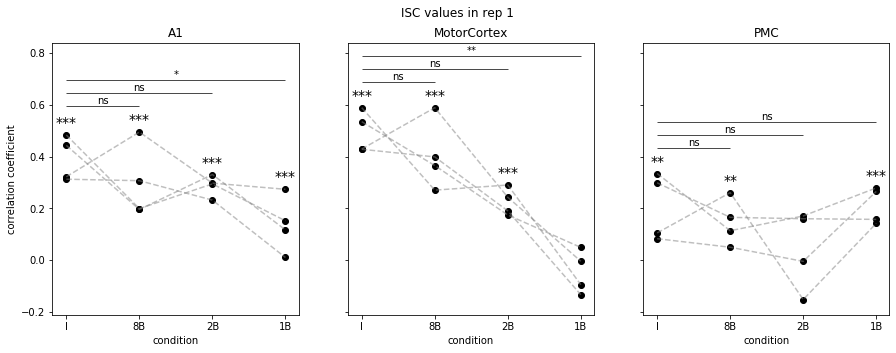

In [9]:
# plot A1, Motor cortex, and PMC together
# create the figure
fig, ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
fig.suptitle('ISC values in rep 1')
ax[0].set_ylabel('correlation coefficient')

for r in range(len(ROIs)):
    roi = ROIs[r]
    ax[r].set_title(roi)
    
    # plot the true ISC values as scatter plot
    ax[r].set_xlabel('condition')
    ax[r].set_xticks(xc)
    ax[r].set_xticklabels(conds)
    for c in range(len(conds)):
        ax[r].scatter(np.full(subj.shape,xc[c]),true_ISC_vals[:,c,r],color='black')
        
        # plot the mean ISC value as a horizontal line
        #ax[r].hlines(np.mean(true_ISC_vals[:,c,r]),xc[c]-0.2,xc[c]+0.2,color='gray')

        # plot as green asterisk(s) if above chance
        p = p_chance[c,r]
        if p < 0.001: ax[r].text(xc[c],np.max(true_ISC_vals[:,c,r])+0.02,
                                 '***',ha='center',va='bottom',fontsize=14)#,color='green')
        elif p < 0.01: ax[r].text(xc[c],np.max(true_ISC_vals[:,c,r])+0.02,
                                 '**',ha='center',va='bottom',fontsize=14)#,color='green')
        elif p < 0.05: ax[r].text(xc[c],np.max(true_ISC_vals[:,c,r])+0.02,
                                 '*',ha='center',va='bottom',fontsize=14)#,color='green')
    
    # plot lines connecting each subjects' ISC values
    for s in subj:
        ax[r].plot(true_ISC_vals[s,:,r],color='gray',linestyle='dashed',alpha=0.5)
    
    # find max for this ROI
    max_ISC = np.max(true_ISC_vals[:,:,r])
    
    # plot lines in blue
    ax[r].hlines(max_ISC+0.1,0,1,linewidth=0.7)#,color='blue')
    ax[r].hlines(max_ISC+0.15,0,2,linewidth=0.7)#,color='blue')
    ax[r].hlines(max_ISC+0.2,0,3,linewidth=0.7)#,color='blue')
    
    p = p_comps[0,r]
    if p <= 0.001: ax[r].text(0.5,max_ISC+0.101,'***',ha='center',va='bottom',fontsize=10)#,color='blue')
    elif p <= 0.01: ax[r].text(0.5,max_ISC+0.101,'**',ha='center',va='bottom',fontsize=10)#,color='blue')
    elif p <= 0.05: ax[r].text(0.5,max_ISC+0.101,'*',ha='center',va='bottom',fontsize=10)#,color='blue')
    else: ax[r].text(0.5,max_ISC+0.101,'ns',ha='center',va='bottom',fontsize=10)#,color='blue')
    
    p = p_comps[1,r]
    if p <= 0.001: ax[r].text(1,max_ISC+0.151,'***',ha='center',va='bottom',fontsize=10)#,color='blue')
    elif p <= 0.01: ax[r].text(1,max_ISC+0.151,'**',ha='center',va='bottom',fontsize=10)#,color='blue')
    elif p <= 0.05: ax[r].text(1,max_ISC+0.151,'*',ha='center',va='bottom',fontsize=10)#,color='blue')
    else: ax[r].text(1,max_ISC+0.151,'ns',ha='center',va='bottom',fontsize=10)#,color='blue')

    p = p_comps[2,r]
    if p <= 0.001: ax[r].text(1.5,max_ISC+0.201,'***',ha='center',va='bottom',fontsize=10)#,color='blue')
    elif p <= 0.01: ax[r].text(1.5,max_ISC+0.201,'**',ha='center',va='bottom',fontsize=10)#,color='blue')
    elif p <= 0.05: ax[r].text(1.5,max_ISC+0.201,'*',ha='center',va='bottom',fontsize=10)#,color='blue')
    else: ax[r].text(1.5,max_ISC+0.201,'ns',ha='center',va='bottom',fontsize=10)#,color='blue')
    
    
# set y limits that make sense with the significance markers
ax[0].set_ylim(top=np.max(true_ISC_vals)+0.25)

#plt.show()
#plt.savefig(output_filepath+'A1_MC_PMC_crop%d_PS%d_LS%d'%(crop,samples_phase_scr,samples_label_shuf),dpi=300) 
plt.savefig(output_filepath+'A1_MC_PMC_crop%d_PS%d_LS%d-indsubj-bw'%(crop,samples_phase_scr,samples_label_shuf),dpi=300)   